# Build an End-to-End Machine Learning Model using PySpark and MLlib (1)
#### Binary Classification with Imbalanced Classes problem

In-Memory computation and Parallel-Processing are some of the major reasons that Apache Spark has become very popular in the big data industry to deal with data products at large scale and perform faster analysis

we are going to use a real world dataset from Home Credit Default Risk competition on kaggle. The target variable is either 0 (applicants who were able to pay back their loans)or 1 (applicants who were NOT able to pay back their loans). it is a binary classification problem with a highly imbalanced target label

## 1. EDA

Data: [Link](https://www.kaggle.com/c/home-credit-default-risk/data?select=application_train.csv)

In [ ]:
import os
import pandas as pd

In [ ]:
#we use the findspark library to locate spark on our local machine
import findspark
findspark.init()

# findspark.init('C:/Users/bokhy/spark/spark-2.4.6-bin-hadoop2.7')    # use the Spark folder path on yr machine

In [ ]:
# Example of Spark session start
# spark = SparkSession.builder.getOrCreate()
# aa = spark.sql('''select 'spark' as hello ''')
# aa.show()

In [ ]:
import pyspark        # only run after findspark.init()
from pyspark.sql import SparkSession

In [4]:
# sc = pyspark.SparkContext(appName="imbalanced_binary_classification")

# initiate our session and read the main CSV file, then we print the #dataframe schema
spark = SparkSession.builder.appName('imbalanced_binary_classification').getOrCreate()

path = 'C:\\Users\\user\\Documents\\R Programming for Data Science\\Datasets'     # path of d folder containing d dataset

new_df = spark.read.csv(os.path.join(path, 'application_train.csv'), header=True, inferSchema=True)    # the dataset
new_df.printSchema()

root
 |-- SK_ID_CURR: integer (nullable = true)
 |-- TARGET: integer (nullable = true)
 |-- NAME_CONTRACT_TYPE: string (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- AMT_GOODS_PRICE: double (nullable = true)
 |-- NAME_TYPE_SUITE: string (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- REGION_POPULATION_RELATIVE: double (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- DAYS_REGISTRATION: double (nullable = true)
 |-- DAYS_ID_PUBLISH: integer (nullable = true)
 |-- OWN_CAR_AG

In [8]:
new_df.show()

+-----+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+--------------------+--------------------+--------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+-----------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+--------------------+-------------------+-------------------+-------------------+--------------+----------------+---------------------------+------------------+--------------+-------------+-------------+-------------+-------------+------------+--------------------+--------------+-----------------------+

##### We are going to drop the SK_ID_CURR column (we don't need it), and rename the “TARGET” column to “label” and see the distribution of our target variable:

In [5]:
drop_col = ['SK_ID_CURR']

# Remove d stated column object from d data
new_df = new_df.select([column for column in new_df.columns if column not in drop_col])

# Rename the stated column
new_df = new_df.withColumnRenamed('TARGET', 'label')    


In [6]:
# Using Pandas inside Spark
new_df.groupby('label').count().toPandas()

,label,count
0,1,24825
1,0,282686


In [7]:
# let's see how everything look in Pandas
import pandas as pd

pd.DataFrame(new_df.take(10), columns= new_df.columns)

,label,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,454500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
6,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,1395000.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0
7,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,1530000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
8,0,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,913500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
9,0,Revolving loans,M,N,Y,0,135000.0,405000.0,20250.0,405000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### let's have a look at the distribution of our target variable: to make it look better, we first convert our spark df to a Pandas

307511


<Axes: xlabel='label', ylabel='count'>

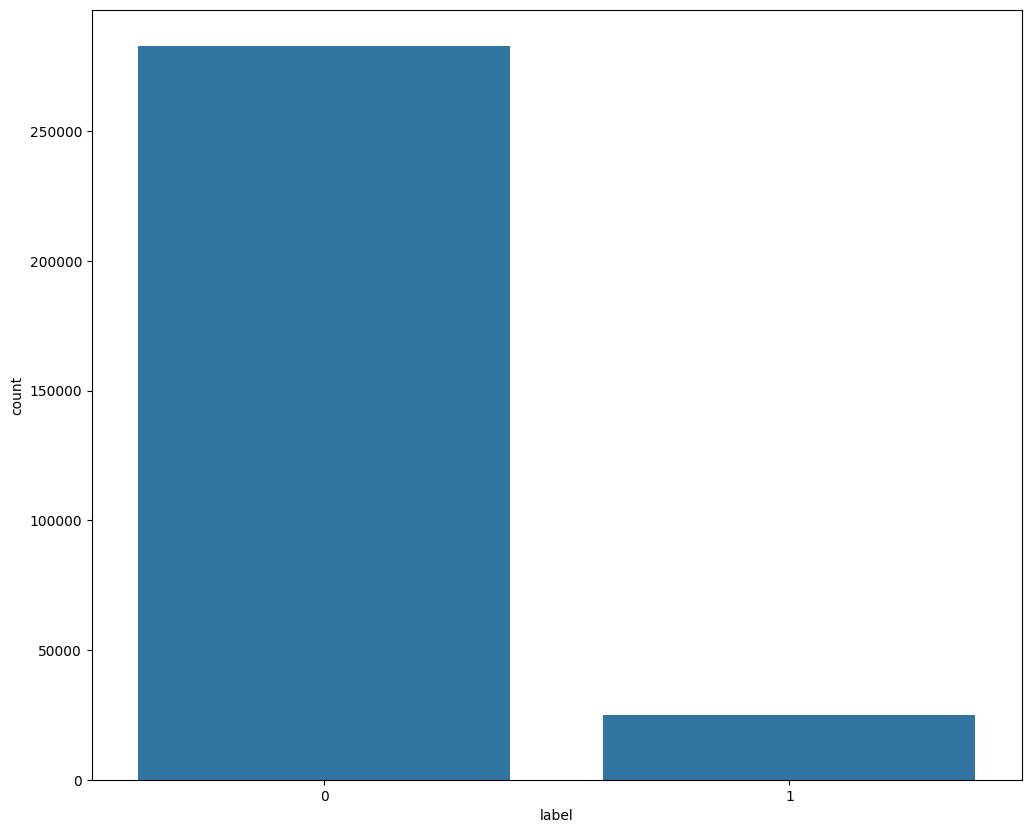

In [10]:
df_pd = new_df.toPandas()
print(len(df_pd))
print(df_pd.shape)

plt.figure(figsize=(12,10))
sns.countplot(x='label', data=df_pd, order=df_pd['label'].value_counts().index)

#### We can see we have a huge case of Imbalanced data

## 2. Data Pre-processing

In [12]:
## [Categorical and Numerical column] ##

# See how many categorical + numerical features:
cat_cols = [item[0] for item in new_df.dtypes if item[1].startswith('string')] 
num_cols = [item[0] for item in new_df.dtypes if item[1].startswith('int') | item[1].startswith('double')][1:]

print(str(len(cat_cols)) + '  categorical features')
print(str(len(num_cols)) + '  numerical features')

16  categorical features
104  numerical features


#### Analyzing missing values in both Pandas and Spark dataframes

In [13]:
## [Missing Values] ##

# we use the below helper function to find more information about the missing values in the Pandas dataframe
def info_missing_table(df_pd):
    """Input pandas dataframe and Return columns with missing value and percentage"""
    mis_val = df_pd.isnull().sum()      # count total of null in each columns in dataframe
# count percentage of null in each columns
    mis_val_percent = 100 * df_pd.isnull().sum() / len(df_pd) 
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1) 
# join to left (as column) between mis_val and mis_val_percent
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'}) 
# rename columns in table
    mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1) 
        
    print ("Your selected dataframe has " + str(df_pd.shape[1]) + " columns.\n"    #.shape[1] : just view total columns in dataframe only.  
    "There are " + str(mis_val_table_ren_columns.shape[0]) +                # .shape[0]: view total rows only
    " columns that have missing values.") #.shape[0] : just view total rows in dataframe
    return mis_val_table_ren_columns

missings = info_missing_table(df_pd)
missings

Your selected dataframe has 121 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
...,...,...
EXT_SOURCE_2,660,0.2
AMT_GOODS_PRICE,278,0.1
AMT_ANNUITY,12,0.0
CNT_FAM_MEMBERS,2,0.0


- There are 67 columns out of 121 that has missing values in them. 
- Most of these 67 columns have more than 50 percent missing values (which is a lot) 
- So fill the numerical missing values with the average of each column and the categorical missing values with the most frequent category of each column.

In [14]:
# Find the number of missing values in each column in the Spark dataframe using helper function
def count_missings(spark_df):
    null_counts = []        
    for col in spark_df.dtypes:    
        cname = col[0]     
        ctype = col[1]      
        nulls = spark_df.where( spark_df[cname].isNull()).count() #check count of null in column name
        result = tuple([cname, nulls])  #new tuple, (column name, null count)
        null_counts.append(result)      #put the new tuple in our result list
    null_counts=[(x,y) for (x,y) in null_counts if y!=0]  #view just columns that have missing values
    return null_counts

In [15]:
miss_counts = count_missings(new_df)
miss_counts
# Displays missing values in each column in a Dictionary key-value format

[('AMT_ANNUITY', 12),
 ('AMT_GOODS_PRICE', 278),
 ('NAME_TYPE_SUITE', 1292),
 ('OWN_CAR_AGE', 202929),
 ('OCCUPATION_TYPE', 96391),
 ('CNT_FAM_MEMBERS', 2),
 ('EXT_SOURCE_1', 173378),
 ('EXT_SOURCE_2', 660),
 ('EXT_SOURCE_3', 60965),
 ('APARTMENTS_AVG', 156061),
 ('BASEMENTAREA_AVG', 179943),
 ('YEARS_BEGINEXPLUATATION_AVG', 150007),
 ('YEARS_BUILD_AVG', 204488),
 ('COMMONAREA_AVG', 214865),
 ('ELEVATORS_AVG', 163891),
 ('ENTRANCES_AVG', 154828),
 ('FLOORSMAX_AVG', 153020),
 ('FLOORSMIN_AVG', 208642),
 ('LANDAREA_AVG', 182590),
 ('LIVINGAPARTMENTS_AVG', 210199),
 ('LIVINGAREA_AVG', 154350),
 ('NONLIVINGAPARTMENTS_AVG', 213514),
 ('NONLIVINGAREA_AVG', 169682),
 ('APARTMENTS_MODE', 156061),
 ('BASEMENTAREA_MODE', 179943),
 ('YEARS_BEGINEXPLUATATION_MODE', 150007),
 ('YEARS_BUILD_MODE', 204488),
 ('COMMONAREA_MODE', 214865),
 ('ELEVATORS_MODE', 163891),
 ('ENTRANCES_MODE', 154828),
 ('FLOORSMAX_MODE', 153020),
 ('FLOORSMIN_MODE', 208642),
 ('LANDAREA_MODE', 182590),
 ('LIVINGAPARTMENTS_MO

In [16]:
# Separate categorical and numerical columns with missing values (based on datatypes)
list_cols_miss=[x[0] for x in miss_counts]
df_miss= new_df.select(*list_cols_miss)

# categorical columns
catcolums_miss=[item[0] for item in df_miss.dtypes if item[1].startswith('string')]  #will select name of column with string data type
print("categorical columns_miss:", catcolums_miss)

print('------------------------------------')

# numerical columns
numcolumns_miss = [item[0] for item in df_miss.dtypes if item[1].startswith('int') | item[1].startswith('double')] #will select name of column with integer or double data type
print("numerical columns_miss:", numcolumns_miss)

categorical columns_miss: ['NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']
------------------------------------
numerical columns_miss: ['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMO

#### Fill/Impute the missing values

In [17]:
# (1) categorical --> Impute using the most frequent category class (ie most frequent unique value)

from pyspark.sql.functions import rank,sum,col

df_Nomiss=new_df.na.drop()     # remove d NAs

for x in catcolums_miss:                  
    mode=df_Nomiss.groupBy(x).count().sort(col("count").desc()).collect()[0][0]     # we collect d unique value with the highest frequency count of each column 
    print(x, mode)          # print name of column and it's most frequent unique value
    new_df = new_df.na.fill({x:mode})        # we impute such unique value for NAs

NAME_TYPE_SUITE Unaccompanied
OCCUPATION_TYPE Laborers
FONDKAPREMONT_MODE reg oper account
HOUSETYPE_MODE block of flats
WALLSMATERIAL_MODE Panel
EMERGENCYSTATE_MODE No


In [18]:
# (2) numerical --> Impute using the mean/average value of each column

from pyspark.sql.functions import mean, round

for i in numcolumns_miss:
    meanvalue = new_df.select(round(mean(i))).collect()[0][0]    # we collect d mean of each column  
    print(i, meanvalue) 
    new_df=new_df.na.fill({i:meanvalue})    # imput using mean

AMT_ANNUITY 27109.0
AMT_GOODS_PRICE 538396.0
OWN_CAR_AGE 12.0
CNT_FAM_MEMBERS 2.0
EXT_SOURCE_1 1.0
EXT_SOURCE_2 1.0
EXT_SOURCE_3 1.0
APARTMENTS_AVG 0.0
BASEMENTAREA_AVG 0.0
YEARS_BEGINEXPLUATATION_AVG 1.0
YEARS_BUILD_AVG 1.0
COMMONAREA_AVG 0.0
ELEVATORS_AVG 0.0
ENTRANCES_AVG 0.0
FLOORSMAX_AVG 0.0
FLOORSMIN_AVG 0.0
LANDAREA_AVG 0.0
LIVINGAPARTMENTS_AVG 0.0
LIVINGAREA_AVG 0.0
NONLIVINGAPARTMENTS_AVG 0.0
NONLIVINGAREA_AVG 0.0
APARTMENTS_MODE 0.0
BASEMENTAREA_MODE 0.0
YEARS_BEGINEXPLUATATION_MODE 1.0
YEARS_BUILD_MODE 1.0
COMMONAREA_MODE 0.0
ELEVATORS_MODE 0.0
ENTRANCES_MODE 0.0
FLOORSMAX_MODE 0.0
FLOORSMIN_MODE 0.0
LANDAREA_MODE 0.0
LIVINGAPARTMENTS_MODE 0.0
LIVINGAREA_MODE 0.0
NONLIVINGAPARTMENTS_MODE 0.0
NONLIVINGAREA_MODE 0.0
APARTMENTS_MEDI 0.0
BASEMENTAREA_MEDI 0.0
YEARS_BEGINEXPLUATATION_MEDI 1.0
YEARS_BUILD_MEDI 1.0
COMMONAREA_MEDI 0.0
ELEVATORS_MEDI 0.0
ENTRANCES_MEDI 0.0
FLOORSMAX_MEDI 0.0
FLOORSMIN_MEDI 0.0
LANDAREA_MEDI 0.0
LIVINGAPARTMENTS_MEDI 0.0
LIVINGAREA_MEDI 0.0
NONLIVING

### Let’s work on how to deal with the Imbalanced Classes in the response variable
There are different methods to mitigate this problem:
* One way is to 'under sample' the majority class or 'over sample' the minority class to make a more balanced results.   
* Another way is to assign 'weights' for each class to penalize the majority class by assigning less weight and boost the minority class by assigning bigger weight.   

We are going to create a new column in the dataset named “weights” and assign the inverse ratio of each class as weights.   
Here is how it’s done:

In [19]:
# adding the new column 'weights' and fill it with ratios based on our response variable
from pyspark.sql.functions import when    # using 'case when' conditional statement

ratio = 0.91

def weight_balance(labels):
    return when(labels == 1, ratio).otherwise(1*(1-ratio))    # using 'case when' conditinal statement on stated column

new_df = new_df.withColumn('weights', weight_balance(col('label')))

In [20]:
pd.DataFrame(new_df.take(10), columns= new_df.columns)

,label,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,weights
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.91
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.09
2,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.09
3,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,0.09
4,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.09
5,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,454500.0,...,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0,0.09
6,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,1395000.0,...,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0,0.09
7,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,1530000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.09
8,0,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,913500.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.09
9,0,Revolving loans,M,N,Y,0,135000.0,405000.0,20250.0,405000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,0.09


## 3. Feature Engineering

PySpark has a great feature engineering handling, so that we do not need to do much for extracting features

1. Apply StringIndexer() to assign indices to each category in our categorical columns
2. Apply OneHotEncoderEstimator() to convert categorical columns to onehot encoded vectors
3. Apply VectorAssembler() to create a feature vector from all categorical and numerical features and we call the final vector as “features”

In [23]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

In [24]:
# we use the OneHotEncoderEstimator from MLlib in spark to convert each v=categorical feature into one-hot vectors
# next, we use VectorAssembler to combine the resulted one-hot vector #and the rest of numerical features into a single vector column. 
# we append every step of the process in a #stages array
stages = []

for categoricalCol in cat_cols:       # Categorical columns
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]


In [25]:
assemblerInputs = [c + "classVec" for c in cat_cols] + num_cols    # using both Categorical and Numeric columns
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

### Let’s put everything into a pipeline. 
Here we are performing a sequence of transformations so we do all of them at once using a pipeline:

In [26]:
from pyspark.ml import Pipeline

cols = new_df.columns

pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(new_df)

new_df = pipelineModel.transform(new_df)

In [27]:
selectedCols = ['features']+cols     # adding/combining features column to columns in d dataset
new_df = new_df.select(selectedCols)

# New dataset after feature engineering:
pd.DataFrame(new_df.take(5), columns=new_df.columns)
# We can see the features column followed by the response column

,features,label,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,weights
0,"(1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.91
1,"(1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.09
2,"(0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.09
3,"(1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,0.09
4,"(1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.09


## 4. Start the Training 

In [28]:
# split the data into training and testin gsets
train, test = new_df.randomSplit([0.80, 0.20], seed = 42)
print(train.count())
print()
print(test.count())

245966

61545


### Logistic Regression

In [29]:
# first we check how Logistic Regression perform 
from pyspark.ml.classification import LogisticRegression

LR = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=15)
LR_model = LR.fit(train)

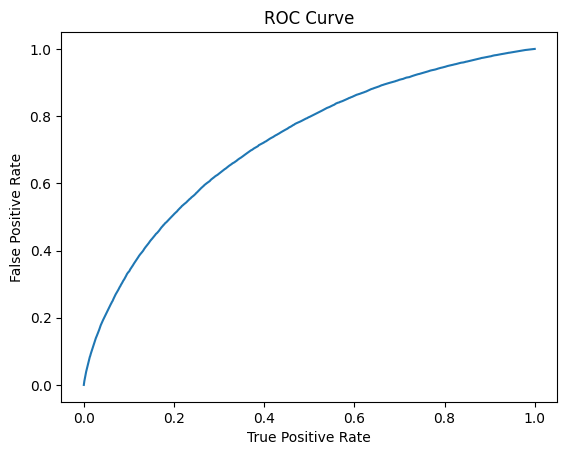

Training set ROC: 0.7237612104112848


In [30]:
# plotting the ROC Curve
trainingSummary = LR_model.summary

print('Training set ROC: ' + str(trainingSummary.areaUnderROC))

roc = trainingSummary.roc.toPandas()

plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

#### Evaluating on the testing set

In [31]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

predictions_LR = LR_model.transform(test)

evaluator = BinaryClassificationEvaluator()
print("Test SET ROC: " + str(evaluator.evaluate(predictions_LR, {evaluator.metricName: "areaUnderROC"})))

Test SET ROC: 0.7193313796802221


#### Gradient Boosting Model

In [32]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=15)
GBT_Model = gbt.fit(train)

In [33]:
# Evaluate using Testing data
gbt_predictions = GBT_Model.transform(test)

evaluator = BinaryClassificationEvaluator()
print("Test SET ROC: " + str(evaluator.evaluate(gbt_predictions, {evaluator.metricName: "areaUnderROC"})))

Test SET ROC: 0.7274247535167813


#### Let's use the Gradient Boosting result then apply hyper-parameter tuning using grid search and after that we run cross validation to better improve the performance of GBT.

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 30])
             .addGrid(gbt.maxIter, [10, 15])
             .build())

cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations.
cvModel = cv.fit(train)

In [ ]:
# Evaluate on test data
gbt_cv_predictions = cvModel.transform(test)

evaluator.evaluate(gbt_cv_predictions)